# Skill estimation of the top 50 PGU Smash Ultimate Professionals using Stan, a simple continuous variable model

In [1]:
from platform import python_version
print(python_version())

import pystan
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

3.9.6


In [2]:
# needed to run multiple chains
import multiprocessing
multiprocessing.set_start_method("fork")

We'll use "stan" to define the model; this will compile an inference engine which can then perform Monte Carlo (and some other) approximate inference procedures to give estimates.

We'll describe the (prior) distribution of skill levels as Gaussian, and then model the probability of Player A winning over Player B as a logistic function of the two players' skill differences, with a scaling coefficient (which we can set or try to learn):

## Parse data from SQLite database: https://github.com/smashdata/ThePlayerDatabase 

In [3]:
import sqlite3 as sq
import ast
import parse as data

con = sq.connect("ultimate_player_database/ultimate_player_database.db")
cur = con.cursor()

In [4]:
# *********************** DATA DICTIONARIES *********************** #

# playerids = set( int(player_id) )
# playerid_to_placement = dict( int(player_id), int(placement) )
# placement_to_playerid = dict( int(placement), int(player_id) )
# playerid_to_name = dict( int(player_id), str(player_tag) )
# name_to_playerid = dict( str(player_tag), int(player_id) )
# matches = [ int(player_1_id), int(player_2_id), int(winner_id) ]
# n = len(playerids)

### player_ids and player_id_to_placement

In [5]:
playerid_to_placement = dict()
placement_to_playerid = dict()

request = cur.execute("select by_id from ranking_seasons limit 1;")
playerid_to_placement_str = ast.literal_eval(request.fetchall()[0][0])

inconsistent_data_playerid = {6905,270293,160103,24835,58557}

change = 0;
for pl_id,place in playerid_to_placement_str.items() :
    if int(pl_id) not in inconsistent_data_playerid :
        playerid_to_placement[int(pl_id)] = place - change
        placement_to_playerid[place - change] = int(pl_id)
    else :
        # hard coded due to inconsistencies in data
        if place != 51: 
            change += 1

playerids = {player_id for player_id in playerid_to_placement}
n = len(playerids)
all_player_id_str = ' or '.join(f'player_id = {p_id}' for p_id in playerids)

### adjust player_ids to correlate to 1-n

In [6]:
playerid_to_adjustedid = dict()
adjustedid_to_playerid = dict()

for i,player_id in enumerate(playerids) :
    playerid_to_adjustedid[player_id] = i + 1
    adjustedid_to_playerid[i + 1] = player_id

### player_id_to_name

In [7]:
playerid_to_name = dict()
name_to_playerid = dict()

request = cur.execute(f"select player_id,tag from players where {all_player_id_str}")
players = request.fetchall()
for player_id,tag in players :
    playerid_to_name[int(player_id)] = tag
    name_to_playerid[tag] = int(player_id)

### matches: every match played between any 2 players from the top 50 players

In [8]:
all_p1_ids_str = ' or '.join(f'p1_id = {p_id}' for p_id in playerids)
all_p2_ids_str = ' or '.join(f'p2_id = {p_id}' for p_id in playerids)

request = cur.execute(f'select p1_id, p2_id,winner_id from sets where ({all_p1_ids_str}) and ({all_p2_ids_str})')
matches = request.fetchall()
matches = [ (int(p1), int(p2), int(win)) for p1,p2,win in matches]
print(f'Total number of matches: {len(matches)}')

Total number of matches: 2976


### StanModel Template

In [9]:
skill_model = """
data {
  int<lower=1> N;             # Total number of players
  int<lower=1> E;             # number of games
  real<lower=0> scale;        # scale value for probability computation
  int<lower=0,upper=1> win[E]; # PA wins vs PB
  int PA[E];                  # player info between each game
  int PB[E];                  # 
}
parameters {
  vector[N] skill;           # skill values for each player
}

model{
  for (i in 1:N){ skill[i]~normal(0,3); }
  for (i in 1:E){
    win[i] ~ bernoulli_logit( (scale)*(skill[PA[i]]-skill[PB[i]]) );
  }   # win probability is a logit function of skill difference
}
"""

### Compile model

In [10]:
import pickle
try:     
    sm = pickle.load(open('skill_model.pkl', 'rb'))
except:
    sm = pystan.StanModel(model_code = skill_model)
    with open('skill_model.pkl', 'wb') as f: pickle.dump(sm, f)

### Evaluate matches and set win, pA, pB lists

In [11]:
win = [1*(w == p1) for p1,_,w in matches]
pA =  [playerid_to_adjustedid[p1] for p1,_,_ in matches]
pB =  [playerid_to_adjustedid[p2] for _,p2,_ in matches]

### Perform MCMC on model and take the empirical average over the samples to get the mean estimate for every player's skill level

In [12]:
scales = [i/10 for i in range(1,10)]
skill_levels = []

for scale in scales :
    skill_data = {
        'N': n,
        'E': len(matches),
        'scale': scale,
        'win': win,
        'PA': pA,
        'PB': pB
    }
    
    fit = sm.sampling(data=skill_data, iter=10000, chains=4)
    samples = fit.extract()
    
    skill_level = [(adjustedid_to_playerid[i+1], skill) for i,skill in enumerate(samples['skill'].mean(0))]
    skill_level.sort(key = lambda x : -x[1])
    
    skill_levels.append(skill_level)
    


Gradient evaluation took 0.000775 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.75 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000907 seconds
1000 transitions using 10 leapfrog steps per transition would take 9.07 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001082 seconds
1000 transitions using 10 leapfrog steps per transition would take 10.82 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001003 seconds
1000 transitions using 10 leapfrog steps per transition would take 10.03 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 200

Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 25.9709 seconds (Warm-up)
               17.1792 seconds (Sampling)
               43.1501 seconds (Total)

Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 26.9088 seconds (Warm-up)
               16.9476 seconds (Sampling)
               43.8564 seconds (Total)

Iteration: 10000 / 

Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteratio

Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 31.6051 seconds (Warm-up)
               42.0778 seconds (Sampling)
               73.683 seconds (Total)

Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 32.0281 seconds (Warm-up)
               50.0325 seconds (Sampling)
               82.0606 seconds (Total)


Gradient evaluation took 0.000771 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.71 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000834 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.34 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001154 seconds
1000 transitions using 10 leapfrog steps per transition would take 11.54 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001196 seconds
1000 transitions using 10 leapfrog steps per transition would take 11.96 seconds.
Adju

### Helper Functions for printing

In [17]:
import math

def printResults(skill_levels) :
    mse = 0
    for i in range(n) :
        playerid,_ = skill_levels[i]
        mse += (i+1 - playerid_to_placement[playerid])**2
    mse /= n
    print(f"\nMEAN SQUARED ERROR: {mse}\n")
    
    print('{:3} {:<12}  {:<16}  {:<15}\n'.format(" ", "ACTUAL", "PREDICTED", "SKILL"))
    for i,(playerid,skill) in enumerate(skill_levels) :
        acutal = playerid_to_name[placement_to_playerid[i+1]]
        predicted = playerid_to_name[playerid]
        print('{:3} {:<12}  {:<16}  {:<15}'.format(i+1, acutal, predicted + f' ({playerid_to_placement[playerid]})', skill))
    
    return mse

def printErrorBiasForHigherPlacements(skill_levels) :
    mse = 0
    alpha = 1
    for i in range(n) :
        playerid,_ = skill_levels[i]
        mse += (i+1 - playerid_to_placement[playerid])**2 * math.exp(alpha*(n+1 - playerid_to_placement[playerid])/n)
    mse /= n
    print(f"\nMEAN SQUARED ERROR WITH BIAS FOR CORRECT HIGHER PLACEMENT: {mse}\n")
    
    return mse

def printMSEByScale(mse, mse_bias, scales) :
    
    print('{:3} {:<12}  {:<16}  {:<15}\n'.format(" ", "scale", "MSE", "MSE_Bias"))
    
    for mse,mse_b,scale in zip(mse, mse_bias, scales) :
        print('{:3} {:<12}  {:<16}  {:<15}'.format(" ", scale, mse, mse_b))


### Results

In [14]:
mse = []
mse_bias = []

for scale, skill_level in zip(scales, skill_levels) :
    print(f'MCMC Sampling with 10,000 iterations with 4 chains on a StanModel with scale level: {scale}')
    
    mse.append(printResults(skill_level))
    mse_bias.append(printErrorBiasForHigherPlacements(skill_level))
    
    print('--------------------------------------------------------------------------------------\n')

MCMC Sampling with 10,000 iterations with 4 chains on a StanModel with scale level: 0.1

MEAN SQUARED ERROR: 113.76

    ACTUAL        PREDICTED         SKILL          

  1 MkLeo         MkLeo (1)         10.979739409030808
  2 Tweek         Tweek (2)         8.820777237980005
  3 Marss         Shuton (5)        7.224228786438038
  4 Samsora       zackray (12)      6.261066748523263
  5 Shuton        ProtoBanham (23)  6.249699229614205
  6 Ally          Glutonny (14)     6.217147782940904
  7 Dabuz         Marss (3)         5.735728106279453
  8 Nairo         Nairo (8)         5.7143598008812875
  9 VoiD          Samsora (4)       5.392393794476569
 10 Light         Light (10)        5.140584921084673
 11 Cosmos        Tea (15)          3.845478185373747
 12 zackray       Dabuz (7)         3.219915948812649
 13 Myran         Salem (22)        2.159916004407288
 14 Glutonny      Nietono (44)      1.9554359011249922
 15 Tea           ESAM (16)         1.899785474449577
 16 ESAM         

    scale         MSE               MSE_Bias       

    0.1           113.76            180.65289712674385
    0.2           109.36            171.1471931049876
    0.3           109.56            170.67117115204704
    0.4           113.2             175.65266193560356
    0.5           113.48            176.0966176608784
    0.6           112.68            174.4411280910711
    0.7           112.76            174.5259795068224
    0.8           112.56            174.16997112151066
    0.9           112.56            174.16997112151066


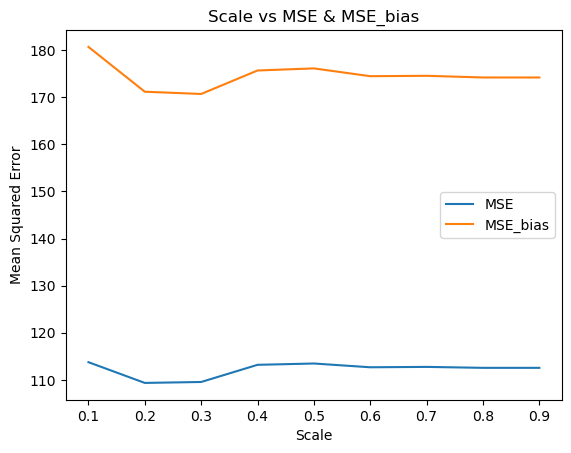

In [20]:
printMSEByScale(mse, mse_bias, scales)

plt.plot(scales, mse, label = 'MSE')
plt.plot(scales, mse_bias, label = 'MSE_bias')
plt.xlabel('Scale')
plt.ylabel('Mean Squared Error')
plt.title('Scale vs MSE & MSE_bias')
plt.legend()

In [16]:
print(f'Best scale: {scales[np.argmin(mse)]} with MSE of {min(mse)}')
print(f'Best scale for more correct higher placements: {scales[np.argmin(mse_bias)]} with MSE of {min(mse_bias)}')

Best scale: 0.2 with MSE of 109.36
Best scale for more correct higher placements: 0.3 with MSE of 170.67117115204704
